# AFSK Digital Correlator Demodulator

This notebook contains a Python implementation of the 1200 baud AFSK demodulator
used in the Mobilinkd TNC3.

This started out as a short demo in Python of the demodulator presented in
[PSoC ® 1 - Simplified FSK Detection (AN2336)](http://www.cypress.com/go/AN2336)
by Dennis Seguine for Cypress Semiconductor.  It has grown quite a bit since.
This now expands on that application note to show a complete HDLC packet
demodulator/decoder.

The purpose of this design is to demodulate 1200 baud amateur radio
packet data.  This encompasses the following topics:

 * AFSK Demodulation (the topic of the above mentioned appliction note)
 * Clock Recovery
 * Data Carrier Detection
 * HDLC Decoding
 * AX.25 Packet Parsing

## AFSK Basics

AFSK -- audio frequency shift keying -- is a method of sending data by
alternating two tones, called *mark* and *space*, to transmit binary
data.

Amateur radio packet data uses the [Bell 202 modem specification](https://en.wikipedia.org/wiki/Bell_202_modem), which specifies a 1200 baud data rate, 1200Hz mark and 2200Hz space tones, a
+/- 10Hz accuracy, and a 1dB flatness for the audio signal.  Bell 202 is a
phase-continuous modulation scheme, meaning that there are no abrupt phase
changes when switching between mark and space tones.

### NRZI

The tones themselves do not encode 0/1 directly.  Rather a [non-return
to zero, inverted (NRZI)](https://en.wikipedia.org/wiki/Non-return-to-zero)
scheme is used.  What this means in laymans terms is that rather than the
tones themselves encoding 0s and 1s, it is a change or no change in tone
that encodes the data.  In NRZI, a change in tone encodes a 0 and no change
in tone encodes a 1.

## AFSK Challenges

Digital signal processing of AFSK data presents a number of challenges.
At the most rudimentary level we have to deal with noise in the signal
and have to overcome low SNR.  In practice, low SNR is actually the least
of our worries.  we are focused on AFSK over FM, which provides a fairly
low SNR until it hits a cliff and falls off very fast.

A much more serious problem we face is twist.  Twist is the amplitude
difference between mark and space tones.  Recall that the Bell 202 spec
requires a 1dB flatness.  Over an amateur radio voice channel, at its
worst we can have twist of +/-9dB and absolutely must handle twist of
6dB.

 1. The voice channel is emphasized on transmission and de-emphasized on
    reception.  Pre-emphasis adds about 6dB to the space tone and then
    subtracts 6dB during de-emphasis.
 2. Not all radios do pre-emphasis.  This can cause up to 6dB in twist
    when received on a radio that does de-emphasis.
 3. Radios that do pre-emphasis may clip the signal after emphasis. This
    causes the higher tone to be lower in amplitude when de-emphasized.
    This can cause up to 6dB in twist when de-emphasized.
 4. Some people may use radios that do not apply de-emphasis.  This may
    present 6dB twist to the modem in the other direction.

Because AFSK is sent over a voice channel, and is sent and received
using equipment designed for voice communication, we have to deal with
audio processing artifacts that are typically avoided in data transmission.
The audio filters, pre-emphasis and de-emphasis filters and limiters used
can cause phase shifts in audio that is imperceptible to human ears but
which can lead to inter-symbol interference (ISI) when sending data.

At least one major TNC manufacturer substituted V.23 modem chips (rather
than Bell 202) in their product  for a time, causing tones to by out of
spec by 100Hz.

All modern digital communications standards use some form of forward
error correction (FEC).  1200 baud packet radio uses no FEC.  A one-bit
error will prevent a packet from being properly decoded.

So, to summarize, our modem must deal with:

 * Low SNR -- noise on top of the actual data signal
 * High twist -- large differences in amplitude between mark and space tones
 * Phase distortion -- mark and space tones not arriving at symbol boundaries
 * Inter-symbol interference -- mark and space tones overlapping due to phase distortion
 * Frequency distortion -- large differences in tone frequency and data rate
 * No error correction -- one bit errors are fatal

These issues make demodulating a packet radio signal more challenging
than 1200 baud over POTS.  In order to acheive best in class performance
the demodulator needs to address all of these issues.

## AFSK Demodulation

As mentioned above, there are a number of steps necessary in order to get to
a decoded packet.  The first step is demodulation -- turning the tones into
bits.  This is a digital correlator demodulator.  It is very simple to implement.
It consumes very little resources which is important when running on low-power
emdedded devices. And it is fairly tolerant of twist.

### What is a Digital Correlator

The correlator involves little more than multiplying the input signal with a
delayed copy of itself.  It is a [comb filter](https://en.wikipedia.org/wiki/Comb_filter).
It causes the signal to destructively and constructively interfere with
itself in such a manner as to demodulate the encoded bitstream.  By adjusting
the delay, we can maximize the difference between mark and space tones.

A digital correlator invovles converting the analog signal into a digital
one by way of a zero-crossing detector, and then applying the same delay
as one would with an analog comb filter.

An analog comb filter is sensitive to twist and is more costly to implement
than a digital one.  A digital correlator is more sensitive to low-frequency
noise and simpler to implement in code or digital circuitry.

-----

Note: it may be cheaper to deal with the twist issues with an analog comb filter.

   $y[n]=x[n]+\alpha x[n-K]$

$\alpha$ is a scaling factor that involves a single multiply per sample.

### Finding the Right Delay

As mentioned above, we are designing a comb filter where the goal is to maximize
the difference between mark and space tones.  This is a problem summed up by:

$y[d] = cos(2\pi f_L d) - cos(2 \pi f_H d)$

where $f_L$ is the low freqency, $f_H$ is the high frequency and $d$ is the delay.

We can graph this equation. When we do, we should see what delays provides the biggest
differences between the two tones.

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,mark_signal,space_signal,corr_signal,n_samples):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (msec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1000,mark_signal[:n_samples],'y-',label='Mark signal')
    plt.plot(time_sec[:n_samples]*1000,space_signal[:n_samples],'g-',label='Space signal')
    plt.plot(time_sec[:n_samples]*1000,corr_signal[:n_samples],'r-',linewidth=2,label='Correlation')
    plt.legend()

Number of samples:  1000


<IPython.core.display.Javascript object>


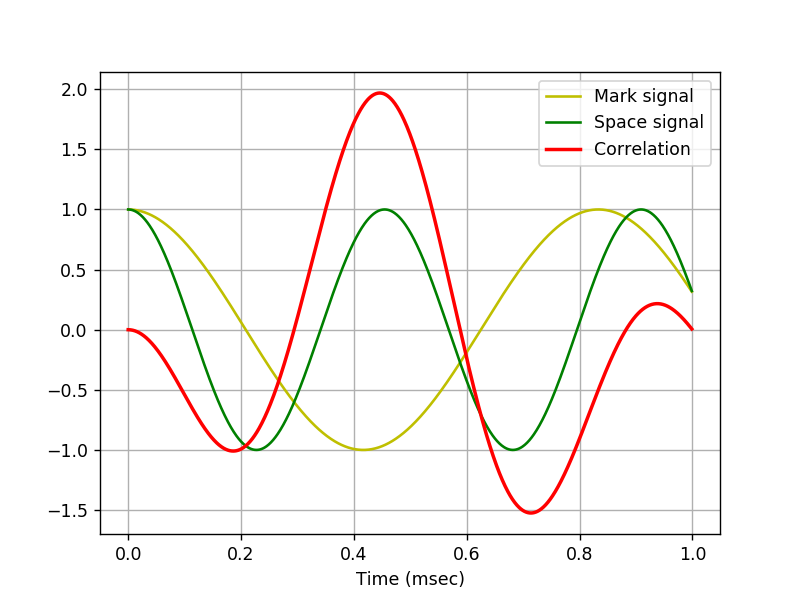

In [48]:
import numpy as np

# Total time
T = 0.001
# Sampling frequency
fs = 1e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signals
mark = np.cos(1200*2*np.pi*t)
space = np.cos(2200*2*np.pi*t)
corr =  np.cos(2200*2*np.pi*t) - np.cos(1200*2*np.pi*t)
# Convert samples to 32-bit integers
# samples = samples.astype(np.int32)
print('Number of samples: ',n)

# Plot signal to the notebook
plot_to_notebook(t,mark,space,corr,1000)

Here we see that a time of 446us will lead to a difference of 2.  This matches the value provided
in the Cypress application note.

As mentioned above, some of the modems found in the wild on APRS actually use the
V.23 standard (1300/2100Hz tones).

Let's let's see what impact that will have on our correlator.

Number of samples:  1000


<IPython.core.display.Javascript object>


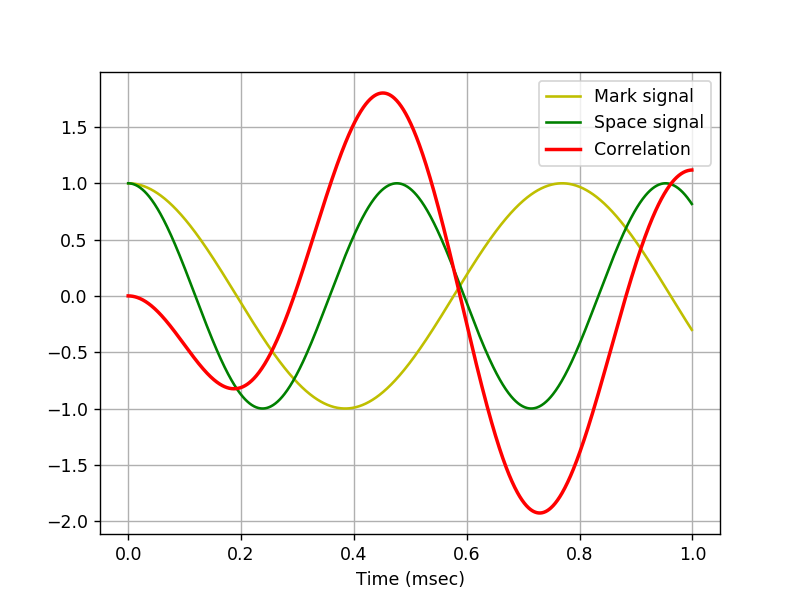

In [23]:
import numpy as np

# Total time
T = 0.001
# Sampling frequency
fs = 1e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signals
mark = np.cos(1300*2*np.pi*t)
space = np.cos(2100*2*np.pi*t)
corr =  np.cos(2100*2*np.pi*t) - np.cos(1300*2*np.pi*t)
# Convert samples to 32-bit integers
# samples = samples.astype(np.int32)
print('Number of samples: ',n)

# Plot signal to the notebook
plot_to_notebook(t,mark,space,corr,1000)

Notice that the maximum is at 730us.  However, the first correlation maximum
corresponds nicely with the maximum for the Bell 202 standard, with a value
of 1.8.  According to the Cypress application note, this should be good enough.

We can try some empircal tests later to determine if using a 730us delay
has a meaningful impact.

---

Towards the end of the Cypress application note, the author states that the sample rate
should be an integer multiple of the two tones.  It is impossible to find a
reasonable sample rate that meets this criterion for both Bell 202 and V.23 since
the two standards have integer multiples of 2, 3, 7, 11 and 13 (it would be
6,006,000 samples per second).

<sub>This difference in sample rate may be more significant than the correlator delay.</sub>

## Implementation

This section will start the implementation of the correlator.  To start, we
will load a 1 second audio file from a [WA8LMF APRS packet test track](http://wa8lmf.net/TNCtest/). 
This is from 10 seconds into track 2.  This is chosen because this one-second
snippet is known to have data at the start, noise in the middle, and a complete
packet towards the end.

The sample file was generated using the following command:

    $ sox TNC_Test_Ver-1.102.wav TNC_Test_Ver-1.102-26400-1sec.wav trim 10 1.05 rate 26400 channels 1

We grabbed a little more than one full second in order to provide the additional data
needed to for the correlator and to accommodate our block sampling code at the end.
We chose a 26400 sample rate because it is an even multiple of our data rate and two
tones.

We will use scipy to read the WAV file.  The audio file is read into a tuple containing
the sample rate and a numpy array of audio data.  Because this is a single channel sample,
the array is 1-dimensional.

In [24]:
from scipy.io.wavfile import read

audio_file = read('TNC_Test_Ver-1.102-26400-1sec.wav')
print(audio_file)

(26400, array([719, 748, 468, ..., 864, 797, 582], dtype=int16))


### Audio Visualization

Lets look at what the audio signal looks like.  The audio picks up in the
middle of a packet transmission, so we should see live data.

Let's look at the first few bits.

Number of samples:  220


<IPython.core.display.Javascript object>


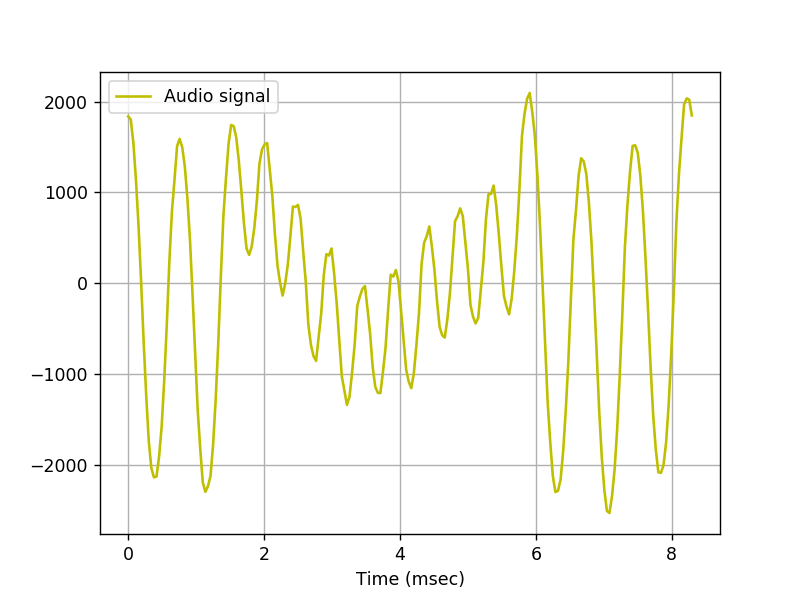

In [25]:
sample_rate = audio_file[0]
audio_data = audio_file[1]

def plot_audio(time_sec,n_samples,signal,filtered=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (msec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1000,signal[:n_samples],'y-',label='Audio signal')
    if filtered is not None:
        plt.plot(time_sec[:n_samples]*1000,filtered[:n_samples],'g-',label='Filtered signal')
    plt.legend()

# Total time
T = 10.0 / 1200.0
# Sampling frequency
fs = sample_rate
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)

print('Number of samples: ',n)

# Plot signal to the notebook
plot_audio(t,n,audio_data[140:])

There is certainly data here.  We can see the distinct differences between the 1200Hz and 2200Hz mark and space tones.  We can also see an example of twist here.  The 2200Hz tone has a significantly lower amplitude than the 1200Hz tone.  This is a rather noisy signal.  There is major low-frequency component that would make digitizing this signal with a zero-crossing detector problematic.

Before this signal can be demodulated it must be filtered.

To do this, we construct a band-pass filter using scipy.filter.  We are going to use a rather steep FIR filter with cut-offs very close to our band of interest (1200-2200Hz).

A FIR filter is used for its linear phase response.  We don't want to add to the ISI with our own digital processing.

[    0     0     0     0     0     0     1     3     5     8     8     5
    -2   -13   -27   -40   -46   -44   -32   -12    11    32    44    44
    32    14     0    -2    13    49    97   143   170   160   104     6
  -118  -244  -340  -381  -352  -258  -120    24   138   192   173    97
     0   -67   -56    62   287   575   850  1021  1001   737   228  -462
 -1216 -1879 -2293 -2336 -1956 -1182  -133  1008  2030  2736  2988  2736
  2030  1008  -133 -1182 -1956 -2336 -2293 -1879 -1216  -462   228   737
  1001  1021   850   575   287    62   -56   -67     0    97   173   192
   138    24  -120  -258  -352  -381  -340  -244  -118     6   104   160
   170   143    97    49    13    -2     0    14    32    44    44    32
    11   -12   -32   -44   -46   -40   -27   -13    -2     5     8     8
     5     3     1     0     0     0     0     0     0]


<IPython.core.display.Javascript object>


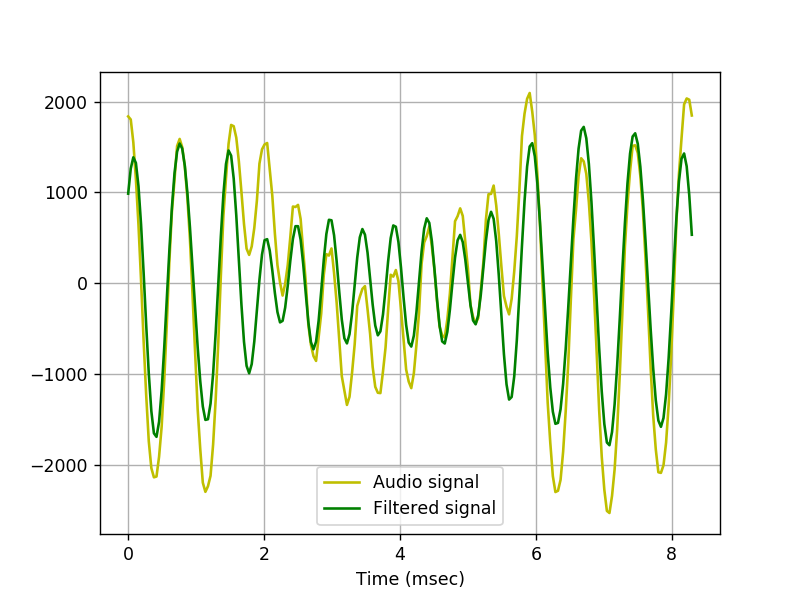

In [40]:
from scipy.signal import lfiltic, lfilter, firwin

class fir_filter(object):
    def __init__(self, coeffs):
        self.coeffs = coeffs
        self.zl = lfiltic(self.coeffs, 32768.0, [], [])
    def __call__(self, data):
        result, self.zl = lfilter(self.coeffs, 32768.0, data, -1, self.zl)
        return result

bpf_coeffs = np.array(firwin(141, [1100.0/(sample_rate/2), 2300.0/(sample_rate/2)], width = None,
        pass_zero = False, scale = True, window='hann') * 32768, dtype=int)

print(bpf_coeffs)

bpf = fir_filter(bpf_coeffs)

filter_delay = len(bpf_coeffs)//2

delay = 12

samples = n+filter_delay+delay
audio_samples = audio_data[140:140+samples]
filtered_audio = bpf(audio_samples)[filter_delay:]
plot_audio(t,n,audio_samples,filtered_audio)

Note that the low-frequency component has been mostly eliminated, allowing
a zero-crossing digitizer to work properly.  The importance of good band-pass
filtering of the input audio signal cannot be overstated.

## Digitizing the Audio Signal

Now lets look at what happens when we digitize the audio signal.

<IPython.core.display.Javascript object>


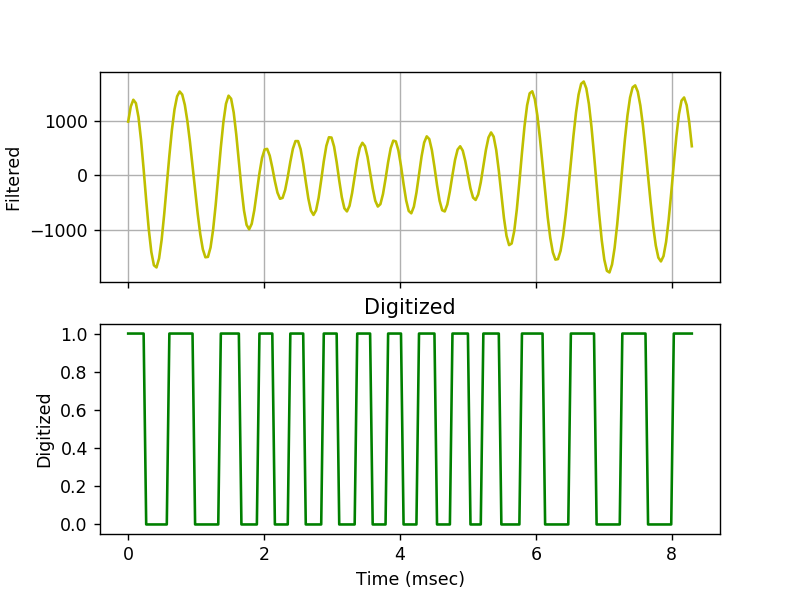

Text(0,0.5,'Digitized')

In [27]:
digitized = np.array([int(x > 0) for x in filtered_audio])

fig, ax = plt.subplots(2, sharex=True)
plt.xlabel('Time (msec)')
plt.title("Digitized")

ax[0].plot(t[:n]*1000,filtered_audio[:n],'y-')
ax[0].set_ylabel("Filtered")
ax[0].grid()
ax[1].plot(t[:n]*1000,digitized[:n],'g-')
ax[1].set_ylabel("Digitized")


The *mark* and *space* tones, visible in the analog input, are also
apparent in the digitized form.  The twist in the analog signal is no
longer a problem.

*Heavy twist can still cause problems for this digital correlator, so it should
not be dismissed as a solved problem here.  But it is a less significant
problem in this modulator than with other demodulator architectures.*

### Comb Filter

Recall that a correlator is a comb filter -- a signal that is multiplied by
a delayed version of itself.  In the binary world, XOR will accomplish the
multiplication for us.

Lets take a look at the digital version, it's delayed version, and the correlator
output.

<IPython.core.display.Javascript object>


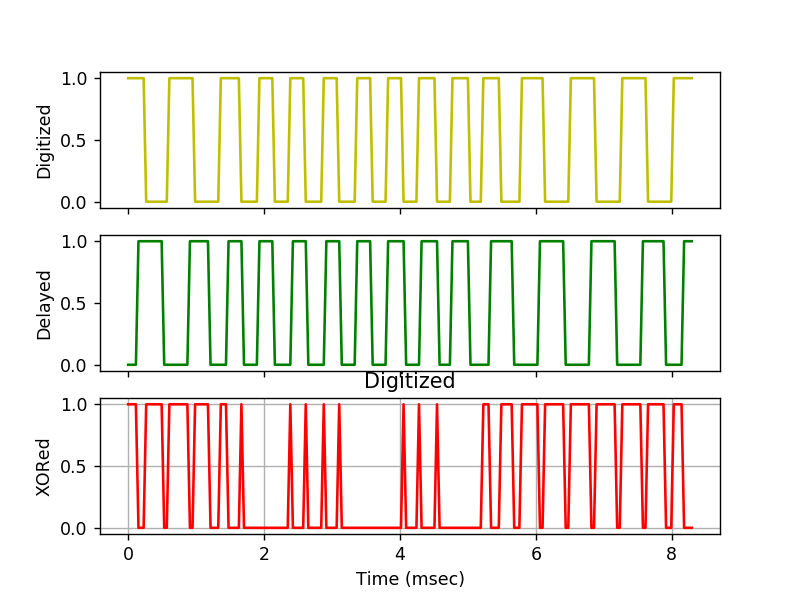

Text(0,0.5,'XORed')

In [28]:
delayed = digitized[delay:]
xored = np.logical_xor(digitized[:0-delay], delayed)

fig, ax = plt.subplots(3, sharex=True)
plt.xlabel('Time (msec)')
plt.title("Digitized")
plt.grid()
ax[0].plot(t[:n]*1000,digitized[:n],'y-')
ax[0].set_ylabel("Digitized")
ax[1].plot(t[:n]*1000,delayed[:n],'g-')
ax[1].set_ylabel("Delayed")
ax[2].plot(t[:n]*1000,xored[:n],'r-')
ax[2].set_ylabel("XORed")

Now that we have digitally correlated the data, the XORed data has the
appearance of a pulse-wide modulated (PWM) signal.  We will need to
normalize and low-pass filter this.  Subtracting 0.5 and the passing
the signal through another FIR filter with a cut-off at 760 Hz will
give us the demodulated signal in analog form.

[   0    0    0    1    3    5    8   11   14   17   20   21   20   17
   11    2   -9  -25  -44  -66  -91 -116 -142 -167 -188 -205 -215 -217
 -209 -190 -156 -109  -47   30  123  230  350  481  622  769  919 1070
 1217 1358 1488 1605 1704 1785 1844 1880 1893 1880 1844 1785 1704 1605
 1488 1358 1217 1070  919  769  622  481  350  230  123   30  -47 -109
 -156 -190 -209 -217 -215 -205 -188 -167 -142 -116  -91  -66  -44  -25
   -9    2   11   17   20   21   20   17   14   11    8    5    3    1
    0    0    0]


<IPython.core.display.Javascript object>


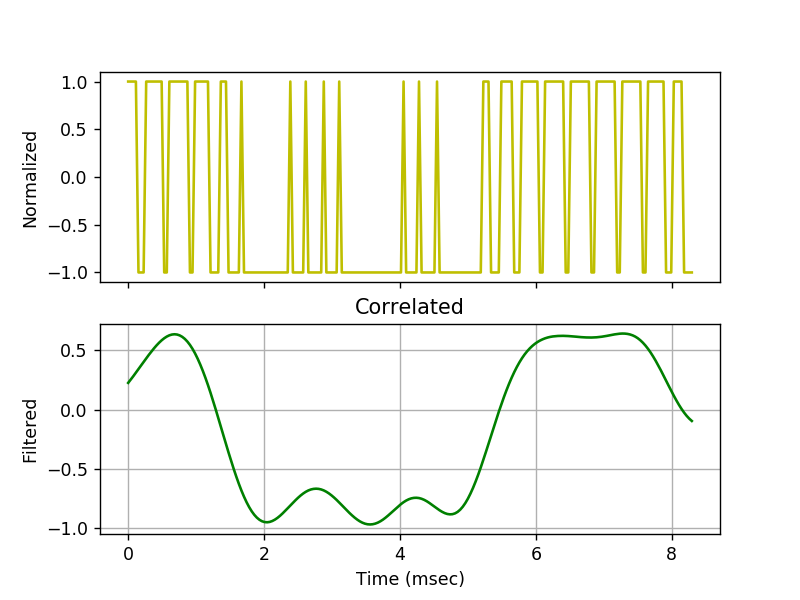

Text(0,0.5,'Filtered')

In [41]:
lpf_coeffs = np.array(firwin(101, [760.0/(sample_rate/2)], width = None,
        pass_zero = True, scale = True, window='hann') * 32768, dtype=int)
print(lpf_coeffs)
lpf = fir_filter(lpf_coeffs)

normalized = (xored - 0.5) * 2.0
correlated = np.append(lpf(normalized), lpf(np.zeros(len(lpf_coeffs))))[len(lpf_coeffs)//2:] # push through zeros to empty filter

fig, ax = plt.subplots(2, sharex=True)
plt.xlabel('Time (msec)')
plt.title("Correlated")
plt.grid()
ax[0].plot(t[:n]*1000,normalized[:n],'y-')
ax[0].set_ylabel("Normalized")
ax[1].plot(t[:n]*1000,correlated[:n],'g-')
ax[1].set_ylabel("Filtered")

Now that we have the data in analog form, we just need to re-digitize the data by passing it through another zero-crossing detector.  A little hysteresis may be warranted.  We will ignore that here.

<IPython.core.display.Javascript object>


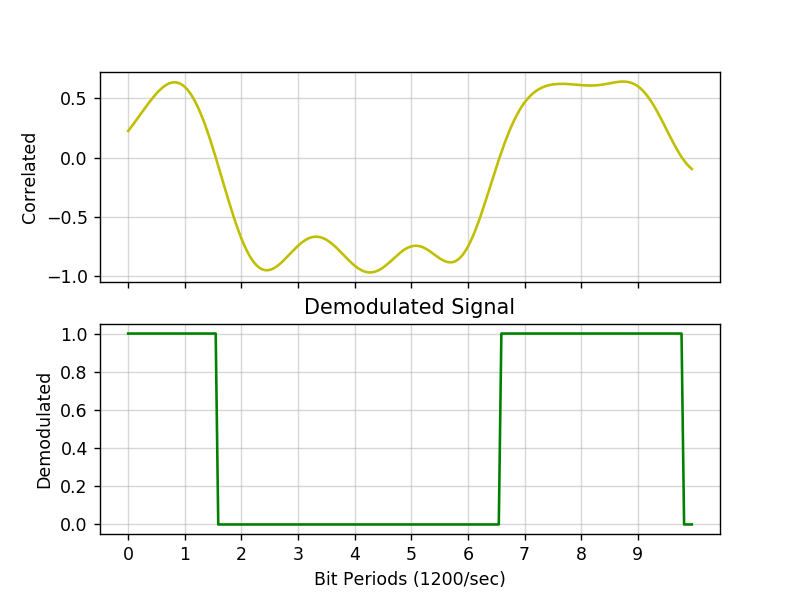

In [30]:
demodulated = np.array([int(x > 0) for x in correlated])

fig, ax = plt.subplots(2, sharex=True)
plt.xlabel('Bit Periods (1200/sec)')
plt.title("Demodulated Signal")

plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.xticks(np.arange(0, 10, 1))

ax[0].plot(t[:n]*1200,correlated[:n],'y-')
ax[0].set_ylabel("Correlated")
ax[0].grid(which='major', alpha=0.5)

ax[1].plot(t[:n]*1200,demodulated[:n],'g-')
ax[1].set_ylabel("Demodulated")
ax[1].grid(which='minor', alpha=0.2)
ax[1].grid(which='major', alpha=0.5)


Note that we have now switched our X axis to "bit periods" rather than ms. Each bit period is 833us.  Now that we have demodulated out signal, what do we do?

Recall that our data is encoded using NRZI.  Tha above digitized data still does not represent the 0s and 1s in our packet directly.  But before we get to that, we have a few more steps to go.

## Clock Recovery

Actually, the hardest part is now before us.  We must implement *Clock Recovery*.  This does two things:

 1. Determines whether we are tracking a data signal or listening to noise.
 2. Recovers the sender's clock.
 
This is necessary to decode the signal.  Recall that in NRZI a "1" is no change in tone during a bit period.  How do we know when to measure that?  Refer to bottom graph in the image above.  Notice that the transistions do not
occur exactly at the same spot in the bit window.  We only know the best time to decode the bit once the sender's clock has been recovered.

The Bell 202 specification requires that the tones and the data clock be within +/- 10Hz <sup>1</sup>.

There is an engineering trade-off to be made here.  Locking on to clocks that vary by more than the 10Hz permitted allow a modem to decode signals from poorly-implemented modems.  However, this can also prevent us from otherwise
accurately tracking weak signals of well-implemented modems.

<sup>1</sup> http://www.softelectro.ru/bell202_en.html

### Eye Diagrams

What we are attempting to do conceptually is to construct an eye diagram, determine
the width of the eye wall or conversely the eye opening, and find the center of the
eye opening.

With the first 6 lines of code, we are going demodulate the first 30 symbols of
our test data and plot those in a window that is exactly one bit-length wide.
This will give us an eye diagram.

<IPython.core.display.Javascript object>


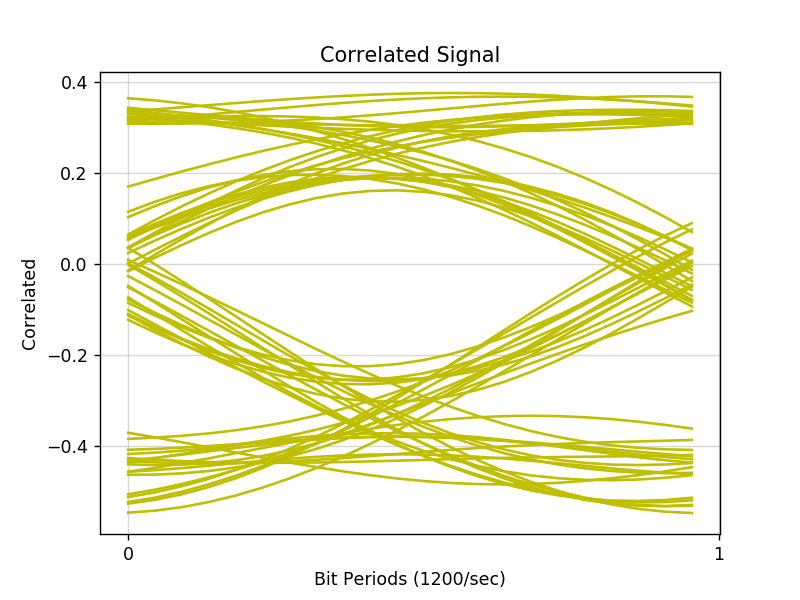

In [44]:
# Select the audio data to demodulate (first 60 bits)
s = audio_data[:22*60 + delay]
# Band-pass filter the audio data
f = np.append(bpf(s), bpf(np.zeros(len(bpf_coeffs)//2)))[len(bpf_coeffs)//2:]
# Digitize the data
d = np.array([int(x > 0) for x in f])
# Delay the data
a = d[delay:]
# XOR the digitized data with the delayed version
x = np.logical_xor(d[:0-delay], a)
# Low-pass filter the PWM signal
c = np.append(lpf(x-0.5), lpf(np.zeros(len(lpf_coeffs)//2)))[len(lpf_coeffs)//2:]

fig, ax = plt.subplots(1, sharex=True)
plt.xlabel('Bit Periods (1200/sec)')
plt.title("Correlated Signal")

plt.grid(which='major', alpha=0.5)
plt.xticks(np.arange(0, 2, 1))

ax.set_ylabel("Correlated")
ax.grid(which='major', alpha=0.5)

for i in range(0, len(c), 22):
    ax.plot(t[:22]*1200,c[i:i+22],'y-')
    

Here one can see the first 60 bit periods of the correlated output.  The
eye is open, there is some jitter around the eye walls, and it is not
centered.  Our job is to write code to quanitify the "openness" of the
eye and to track its center.

Doing this requires that we see a number of mark/space transitions in
order to build up the image above, just as we do to lock the PLL below.
This is the purpose of the preamble (TX Delay) sent with a packet.  It
allows a demodulator to see a number of transistions and lock a PLL to
the data carrier.  Set the TX Delay value too small and the demodulator
on the remote end may not be able to lock in time.

If we plot the digitized demodulated signal, this is what we see:

<IPython.core.display.Javascript object>


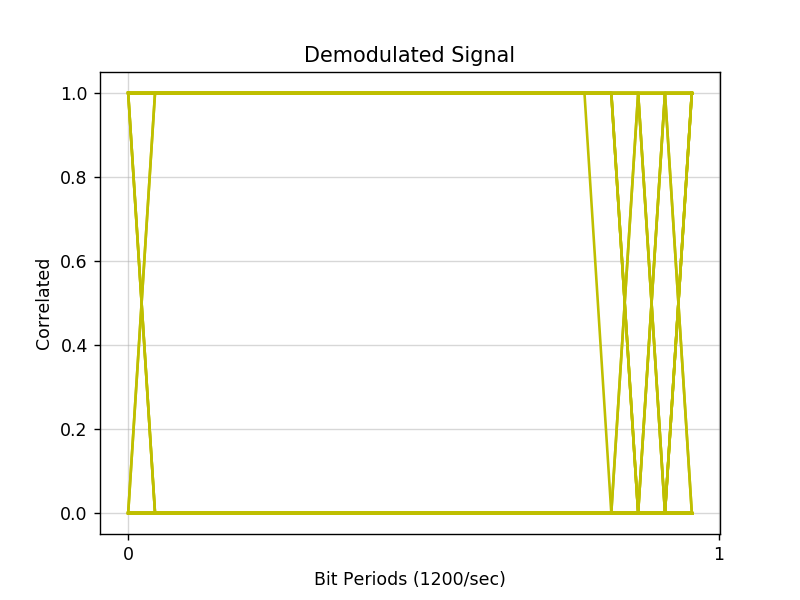

In [45]:
# Digitize the correlated output.
dx = np.array([int(x > 0) for x in c])

fig, ax = plt.subplots(1, sharex=True)
plt.xlabel('Bit Periods (1200/sec)')
plt.title("Demodulated Signal")

plt.grid(which='major', alpha=0.5)
plt.xticks(np.arange(0, 2, 1))

ax.set_ylabel("Correlated")
ax.grid(which='major', alpha=0.5)

for i in range(0, len(dx), 22):
    ax.plot(t[:22]*1200,dx[i:i+22],'y-')


With the digitized signal, the task is a little easier to understand.  We just need to determine whether the width of the eye wall (the signal jitter) matches a specified threshold.  The openness of the eye, or conversely the thinness of the eye wall, allows us to measure the carrier signal.  We need a threshold value at which we say that a data carrier is detected.  The value we use was determined empirically.

We also determined that we need to allow for some amount of slack after the signal is locked in order to deal with noise and with clocks that do not exactly align with our own.

Note here that a single noise event would show up as a transition in the middle of the eye.  We may be able to use that for error detection and correction.

Note that already, with only a few lines of Python code, we can demodulate an AFSK signal.

### Digital PLL

In order to do clock recovery, we need to implement a digital PLL.  This requires a couple of supporting classes -- an IIR filter for loop and lock filtering, and hysteresis for locking/unlocking.

The PLL is implemented in the [DigitalPLL.py](DigitalPLL.py) module included in this repo.  It is a little large to be included inline in this document. 

In [33]:
from DigitalPLL import DigitalPLL

This digital PLL allows us to measure the jitter, determine, based on the jitter level, whether
it is locked to a data carrier, and to indicate the expected center of the eye for sampling.

Jitter is measured as the absolute value difference from the expected symbol duration (here exactly
22 samples).  The PLL can be either advanced or retarded when a tone transition occurs depending on
whether the transition was later than expected or earlier.

Hysteresis is used to lock/unlock the PLL.  In order to lock we require the jitter to be
1.1 samples wide or less.  And it will unlock when jitter rises above 4.4 samples.

The PLL outouts a signal when at the center of the eye -- when it is most likely to be truly high
or truly low.

### Reading the Bitstream

Now that we have our PLL, lets take a look at what happens when we lock onto the data stream.

<IPython.core.display.Javascript object>


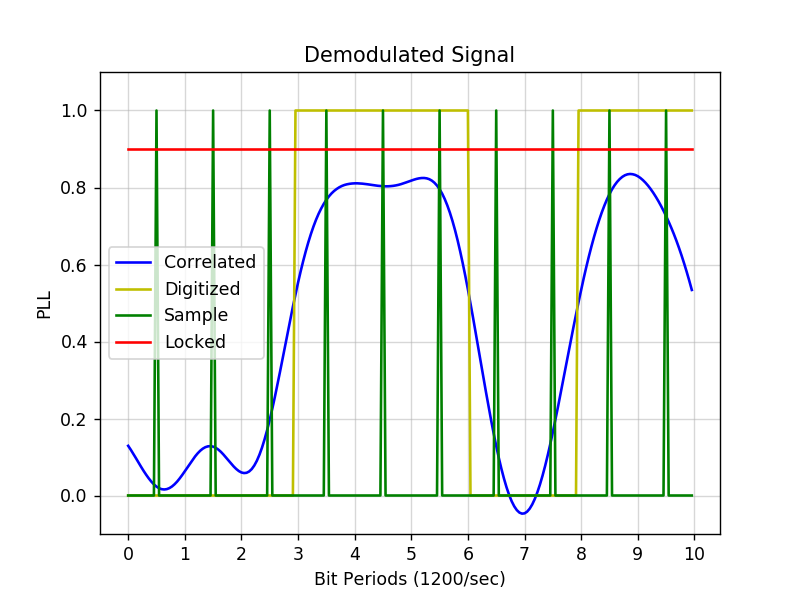

In [47]:
pll = DigitalPLL(sample_rate, 1200.0)

locked = np.zeros(len(dx), dtype=int)
sample = np.zeros(len(dx), dtype=int)

for i in range(len(dx)):
    sample[i] = pll(dx[i])
    locked[i] = pll.locked()

# Total time
T = 10.0 / 1200.0
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)

fig, ax = plt.subplots(1, sharex=True)
plt.xlabel('Bit Periods (1200/sec)')
plt.title("Demodulated Signal")

plt.grid(which='major', alpha=0.5)
plt.xticks(np.arange(0, 11, 1))

ax.set_ylabel("PLL")
ax.grid(which='major', alpha=0.5)
ax.set_ylim(-0.1,1.1)

ax.plot(t*1200,c[220:440]+0.5,'b-', label="Correlated")
ax.plot(t*1200,dx[220:440],'y-', label="Digitized")
ax.plot(t*1200,sample[220:440],'g-', label="Sample")
ax.plot(t*1200,locked[220:440] * 0.8 + 0.1,'r-', label="Locked")
plt.legend()

Here you can see that the PLL has locked onto the data (red line high). The green spikes are the signals to tell the demodulator when to sample -- when it is at the center of the bit/eye.  And you can see that the bit transitions happen fairly equidistant from the surrounding sample signals.

### NRZI

Our next job is to translate these tones (and tone changes) into a bitstream.  For that, we need to implement the NRZI algorithm.  It is rather straight-forward.

In [35]:
class NRZI:

    def __init__(self):

        self.state = False

    def __call__(self, x):
        
        result = (x == self.state)
        self.state = x
        return result

nrzi = NRZI()
    
data = [int(nrzi(x)) for x,y in zip(dx, sample) if y]
print(data, len(data))

[0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1] 60


Here you can see the actual bitstream that we have demodulated from the first 50ms of the audio file.

We cannot actually do anything with this data.  The data at the beginning of this one second
of audio is the very tail end of a packet.  But lets take a look at the entire second of audio.

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


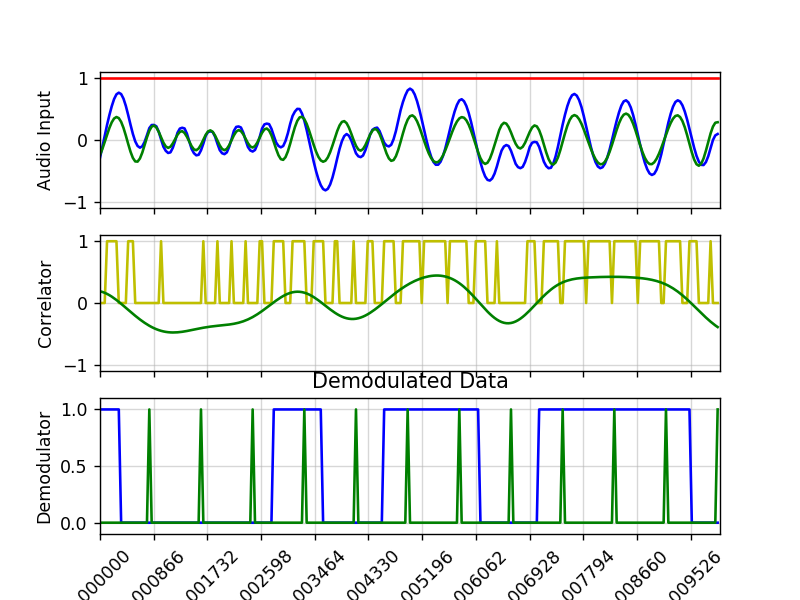

In [49]:
from matplotlib import animation, rc
from IPython.display import HTML

# Band-pass filter the audio data
f = np.append(bpf(audio_data[:26400]), bpf(np.zeros(filter_delay)))[filter_delay:]
# Digitize the data
d = np.array([int(x > 0) for x in f])
# Delay the data
a = d[delay:]
# XOR the digitized data with the delayed version
x = np.logical_xor(d[:0-delay], a)
# Low-pass filter the PWM signal
c = np.append(lpf(x-0.5), lpf(np.zeros(len(lpf_coeffs)//2)))[len(lpf_coeffs)//2:]
# Digitize the tone transistions
dx = np.array([int(x > 0) for x in c])
# Create the PLL
pll = DigitalPLL(sample_rate, 1200.0)

locked = np.zeros(len(dx), dtype=int)
sample = np.zeros(len(dx), dtype=int)

# Clock recovery
for i in range(len(dx)):
    sample[i] = pll(dx[i])
    locked[i] = pll.locked()
    
nrzi = NRZI()
    
data = [int(nrzi(x)) for x,y in zip(dx, sample) if y]

# print(len(audio_data), len(f), len(d), len(a), len(x), len(c), len(dx))

# Time vector in seconds
t = np.linspace(0, 0.01, sample_rate/100.0, endpoint=False)

fig, ax = plt.subplots(3, sharex=True)
plt.xlabel('Bit Periods (1200/sec)')
plt.title("Demodulated Data")
plt.rcParams["animation.html"] = "jshtml"

plt.grid(which='major', alpha=0.5)

ax[0].set_ylabel("Audio Input")
ax[0].grid(which='major', alpha=0.5)
ax[0].set_ylim(-1.1, 1.1)
ax[0].set_xlim(0.0,0.01)
plt.xticks(np.arange(0, .01, .000866), rotation=45)

in_line, = ax[0].plot([], [], 'b-', label="Audio Input")
bpf_line, = ax[0].plot([], [], 'g-', label="Filtered Audio")
lock_line, = ax[0].plot([], [], 'r-', label="PLL Lock")

ax[1].set_ylabel("Correlator")
ax[1].grid(which='major', alpha=0.5)
ax[1].set_ylim(-1.1, 1.1)

xor_line, = ax[1].plot([], [], 'y-')
lpf_line, = ax[1].plot([], [], 'g-')

ax[2].set_ylabel("Demodulator")
ax[2].grid(which='major', alpha=0.5)
ax[2].set_ylim(-0.1, 1.1)

demod_line, = ax[2].plot([], [], 'b-')
sample_line, = ax[2].plot([], [], 'g-')

def init():
    in_line.set_data(t, np.zeros(len(t)))
    bpf_line.set_data(t, np.zeros(len(t)))
    lock_line.set_data(t, np.zeros(len(t)))
    xor_line.set_data(t, np.zeros(len(t)))
    lpf_line.set_data(t, np.zeros(len(t)))
    demod_line.set_data(t, np.zeros(len(t)))
    sample_line.set_data(t, np.zeros(len(t)))
    return (in_line,bpf_line,lock_line,xor_line,lpf_line,demod_line,sample_line)

def animate(i):
    s = int(i * 264)
    e = s + 264
    in_line.set_data(t, audio_data[s:e]/2048.0)
    bpf_line.set_data(t, f[s:e]/2048.0)
    lock_line.set_data(t, locked[s:e])
    xor_line.set_data(t, x[s:e])
    lpf_line.set_data(t, c[s:e])
    demod_line.set_data(t, dx[s:e])
    sample_line.set_data(t, sample[s:e])
    return (in_line,bpf_line,lock_line,xor_line,lpf_line,demod_line,sample_line)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=99, interval=200, blit=True)

The above animation is one second of audio data, slowed down to 1/20th speed. There are a number of things we can observe here.

The Audio Input data shows raw and filtered audio, along with our PLL lock signal.  The PLL is immediately locked to the data signal at the start of the data, then encounters noise and loses lock, and then regains the lock when
new data is present.

The correlator output shows what we have seen earlier.  Notice how the correlator behaves when it encounters the noise in the middle of the sample data.

Notice the sample signals (the green spikes in the Demodulator pane) readjusting as the PLL has to relock to the data stream and then being fairly solid once the PLL is locked.

Now that we have our bitstream, we need to decode it.

## HDLC

Data is packetized using [High-Level Data Link Control (HDLC)](https://en.wikipedia.org/wiki/High-Level_Data_Link_Control).  In our modem, all that we care about is the
framing component of HDLC.  At the framing level, HDLC is a bit-oriented
protocol.  Frames start with a preamble of 0x7E flag sequences (or, more
accurately, the binary flag sequence "01111110").  It contains bit-stuffed
data, a 16-bit CRC (also bit-stuffed) and another flag sequence.

The things we will cover in this section are:

 * Flag sequence & preamble
 * Bit stuffing
 * CRC-16 polynomial
 * Closing flag sequence

### Flags

A number of 0x7E flags are sent in sequence (called a preamble)<sup>1</sup> at the start of the packet.  This allows our PLL to lock on to the incoming data carrier (clock recovery). The first sequence that does not match the flag sequence begins the the start of data.  The end of the packet is signified by another flag sequence<sup>2</sup>.

These flag sequences are the way we determine the start and end of an HDLC packet.  Only when we see the last flag sequence do we know what the final length of the packet is.

<sup>1</sup> At least one TNC vendor does something very different, sending alternating 0/1 bits as the preable and sending only a single flag at the start of the packet.

<sup>2</sup> It is important to note that a station can transmit packets back-to-back with only a single flag byte in between.  That one flag serves as both the end of packet indicator and as start of packet indicator.

### Bit Stuffing

Notice that the flag sequence consists of 6 consecutive ones.  A flag sequence is the only place that 6 consecutive ones will appear in the bitstream.

How is that possible when sending binary data?

This is done via *bit stuffing*.  Any time 5 consecutive 1's have been sent, a 0 is *stuffed* into the bitstream and discarded by the receiver.  It does not matter whether the next bit is a 0 or a 1 -- a stuffed 0 always follows the fifth consecutive 1.

The HDLC decoder is modeled as a state machine -- SEARCHING for a flag byte, HUNTING for the start of the packet, FRAMING the bitstream into bytes and (while discarding stuffed bits), returning a packet when the next flag is encountered, then going back to HUNTING.

### CRC

At the end of the bitstream, in the last two bytes, is a CRC-16 checksum.  Only when the CRC checksum passes is the packet considered "good".  Many TNCs offer an option (PASSALL) to pass all packets, including those that fail a checksum.  This is useful when a human operator is present and is visually inspecting the packets.

The CRC is a 16-bit [CRC-CCITT](https://en.wikipedia.org/wiki/Cyclic_redundancy_check) checksum over all of the data.  CRCs are expressed as polynomials reflecting their bitwise operations.  The polynomial used for CRC-CCITT is

$x^{16} + x^{12} + x^5 + 1$

[CRC.py](CRC.py) implements the CRC-CCITT in Python using a lookup table. This is included in this repo.  The TNC3 uses an ARM Cortex-M4 processes with dedicated CRC hardware.  It uses this hardware to offload the CRC calculation.

### Decoding

The [HDLC.py](HDLC.py) module implements the HDLC decoder state machine.  It accepts one bit of data at a time and will return a frame when one has been successfully decoded.  This code, too, is a large enough that it would interrupt the flow of the document if included inline.

Lets take a look at what we get out of it.

In [50]:
from HDLC import HDLC

nrzi = NRZI()
hdlc = HDLC()

decoded = None

for b,s,l in zip(dx, sample, locked):
    if s:
        packet = hdlc(nrzi(b), l)
        if packet is not None:
            print(packet)
            decoded = packet[1]

(61624, '\x82\xa0¦ddh`\x96\x88l\x8c¬\xa0d\x9cl\x8a°@@â®\x92\x88\x8ab@a\x03ð>152343z[224]*We know most of your faults!!!\r')


Here we see the raw AX.25 packet.  This contains the MYCALL, TOCALL, VIA and data fields.  All but the data fields are encoded.

## AX.25 Decoding

Now we need to decode the AX.25 packet so that it is human readable.  The [AX25.py](AX25.py)
module will do that for us.


In [38]:
from AX25 import AX25

print(AX25(decoded))

KD6FVP-4>APS224,N6EX-2,WIDE1-1:>152343z[224]*We know most of your faults!!!?


## Summary

This shows how to go from audio file to decoded packet in a few lines of Python code.  Hopefully this has provided some insight into how AFSK decoding can be done.

We have still left a few of the challenges unresolved in this short bit of code.  Maybe we will have more on that later.  I will say that one way that the Mobilinkd TNC3 deals with the challenge of twist is to run 3 decoders in parallel, each tuned for different levels of twist.

Comments or questions?  Please send email. If you notice a bug or if something is not clear, please let me know.